# Snapshot Graphs
Instantaneous shift and transmission graphs 

In [2]:
from AD_analysis import *
import Atmospheric_diffraction as atm_shift

The code mainly draws on the following steps, with key variables described:

>analysis=AD_analysis()

This gets the class

====
>analysis.load_wave('LR','NIR','IY','H') 

This function loads the wavelengths that will be used for the shift calculations. 

First variable is LR or HR

Second variable is NIR or VIS

Third/fourth variables are the start/end bands. These can be the same, e.g. 'B', 'B'.

====
>analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])

OR
>analysis.load_airmasses(HA_range=[0,1,2],targ_dec= 0 * u.degree)
This function loads the airmasses to calculate the shifts for.

Can use 1) zenith angles (ZA_range)
OR 2) hour angles (HA_range); the declination is -25.3 deg by default, change with targ_dec=X

====
>analysis.calculate_shifts(fibrecentre_waveref = 1.1 * u.micron,reposition=True, guide_waveref=5 * u.micron)

This function calculates the shifts for the generated wavelengths and airmasses

fibrecentre_waveref is the aperture wavelength reference for original position

guide_waveref is the telescope guiding wavelength reference

reposition = TRUE or FALSE is a setting that determines whether the fibre is aligned on the aperture wavelength reference for each sequential airmass

====
>analysis.calculate_transmissions(method="numerical moffat") 

This function calculates the transmissions for the shifts using one of several methods

method can be 1) analytical gaussian, 2) numerical gaussian, 3) numerical moffat, or 4) numerical durham

====

These functions can be used in many ways for different plots/analysis of transmissions/shifts

Most of these function have other optional variables, e.g., scale for the numerical simulations, whether to change FWHM with airmass and wavelength. These are described in the relevant function notes

## Snapshot Shifts over Observation
#### Wavelength vs Displacement for various airmasses, and Displacement vs Airmass for various wavelengths
Can use either HA or ZA for airmasses

In [3]:
#Following function is used to plot the described graphs
def shift_plot_v0(input_parameters,output_parameters,conditions):
    #HA plots:
    if input_parameters['HA_range'] != []: 
        HA_range=input_parameters['HA_range']

        #1) wavelength vs displacement for different HA 
        centre_shift=atm_diff.diff_shift(input_parameters['fibrecentre_waveref'],output_parameters['airmasses'][0],input_parameters['guide_waveref'],conditions)
        T_arc = lambda T_mm: T_mm * analysis.plate_scale
        T_mm = lambda T_arc: T_arc / analysis.plate_scales
        
        fig, ax = plt.subplots(figsize=(10,7))
        ax2 = ax.secondary_yaxis("right", functions=(T_arc, T_mm))
        
        if input_parameters['reposition'] == False: #If repositioned, wavelength reference centre is meaningless as relative position changes
            plt.axhline(-centre_shift.value,linewidth=0.5,color='red', label='Wavelength Reference Centre')
            
        for i in range(0,len(output_parameters['airmasses'])):
            plt.plot(output_parameters['wave_wavelengths'],output_parameters['shifts'][i],label="HA = %2.2fh" %(HA_range[i]))
            
        plt.axhline(0,linewidth=0.8,color='black',label='Fibre Centre')
        plt.axhline(output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',label='Fibre Boundary',linestyle='--')
        plt.axhline(-output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',linestyle='--')
        plt.title('Wavelength Reference %s, Fibre Centre on %s, Dec = %2.2f deg' %(input_parameters['guide_waveref'],input_parameters['fibrecentre_waveref'],input_parameters['targ_dec'].value))
        plt.legend(loc='best')
        ax.set_ylabel('Displacement from Fibre Centre (arcsec)')
        ax2.set_ylabel('Displacement from Fibre Centre (mm)')
        ax.set_xlabel('Wavelength (nm)')

        #2) Displacement vs HA for different wavelengths
        to_HA = lambda ZA_vals: atm_diff.ZA_2_HA(ZA_vals,input_parameters['targ_dec'])
        to_ZA = lambda HA_vals: atm_diff.HA_2_ZA(HA_vals,input_parameters['targ_dec'])
        fig, ax = plt.subplots(figsize=(12,7))
        ax2 = ax.secondary_yaxis("right", functions=(to_ZA, to_HA))
        
        if input_parameters['reposition'] == False: #If repositioned, wavelength reference centre is meaningless as relative position changes
            plt.axvline(-centre_shift.value,linewidth=0.5,color='red',label='Guiding Reference')
            
        xvals=np.linspace(-1,1,len(output_parameters['wave_wavelengths']))
        c=np.tan(xvals)
        
        for i in range(0,len(output_parameters['shifts'])):
            yvals=np.full(len(output_parameters['shifts'][i]),HA_range[i])
            plt.scatter(output_parameters['shifts'][i],yvals,c=c)
            norm = plt.Normalize(output_parameters['wave_wavelengths'].value.min(), output_parameters['wave_wavelengths'].value.max())
            points = np.array([output_parameters['shifts'][i], yvals]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, cmap='viridis', norm=norm)
            lc.set_array(output_parameters['wave_wavelengths'].value)
            lc.set_linewidth(2)
            line=ax.add_collection(lc)
            
        fig.colorbar(line)
        plt.axvline(0,linewidth=0.7,color='black',label='Aperture Centre')
        plt.axvline(output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',label='Aperture Boundary',linestyle='--')
        plt.axvline(-output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',linestyle='--')
        plt.xlabel('Displacement from Aperture Centre (arcsec)')
        plt.ylabel('Hour Angle (h)')
        ax2.set_ylabel("Zenith Angle (deg)")
        plt.yticks(np.linspace(min(HA_range),max(HA_range),len(HA_range)))
        plt.legend()
        plt.title('Guiding Reference = %s, Aperture Centre = %s, Dec = %2.2f deg' %(input_parameters['guide_waveref'],input_parameters['fibrecentre_waveref'],input_parameters['targ_dec'].value))    
  
    #ZA plots
    if input_parameters['ZA_range'] != []: #If plot is True and Zenith Angle values are used, plot the 2 graphs
        ZA_range=input_parameters['ZA_range']

        #1) wavelength vs displacement for different ZA
        centre_shift=atm_diff.diff_shift(input_parameters['fibrecentre_waveref'],output_parameters['airmasses'][0],input_parameters['guide_waveref'],conditions)
        T_arc = lambda T_mm: T_mm * analysis.plate_scale
        T_mm = lambda T_arc: T_arc / analysis.plate_scale
        fig, ax = plt.subplots(figsize=(10,7))
        ax2 = ax.secondary_yaxis("right", functions=(T_arc, T_mm))
        if input_parameters['reposition'] == False: #If repositioned, wavelength reference centre is meaningless as relative position changes
            plt.axhline(-centre_shift.value,linewidth=0.5,color='red', label='Wavelength Reference Centre')
        for i in range(0,len(output_parameters['airmasses'])):
            plt.plot(output_parameters['wave_wavelengths'],output_parameters['shifts'][i],label="ZA = %2.2f deg" %(ZA_range[i]))
        plt.axhline(0,linewidth=0.8,color='black',label='Fibre Centre')
        plt.axhline(output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',label='Fibre Boundary',linestyle='--')
        plt.axhline(-output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',linestyle='--')
        plt.legend(loc='best')
        ax.set_ylabel('Displacement from Fibre Centre (arcsec)')
        ax2.set_ylabel('Displacement from Fibre Centre (mm)')
        ax.set_xlabel('Wavelength (nm)')
        plt.ylim(-0.61,0.61)
        plt.title('Guiding Reference = %s, Aperture Reference = %s' %(input_parameters['guide_waveref'],input_parameters['fibrecentre_waveref']))

        #2) Displacement vs ZA for different wavelengths
        fig, ax = plt.subplots(figsize=(10,7))
        
        if input_parameters['reposition'] == False: #If repositioned, wavelength reference centre is meaningless as relative position changes
            plt.axvline(-centre_shift.value,linewidth=0.5,color='red',label='Wavelength Reference Centre')
            
        xvals=np.linspace(-1,1,len(output_parameters['wave_wavelengths']))
        c=np.tan(xvals)
        
        for i in range(0,len(output_parameters['shifts'])):
            yvals=np.full(len(output_parameters['shifts'][i]),ZA_range[i])
            plt.scatter(output_parameters['shifts'][i],yvals,c=c)
            norm = plt.Normalize(output_parameters['wave_wavelengths'].value.min(), output_parameters['wave_wavelengths'].value.max())
            points = np.array([output_parameters['shifts'][i], yvals]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, cmap='viridis', norm=norm)
            lc.set_array(output_parameters['wave_wavelengths'].value)
            lc.set_linewidth(2)
            line=ax.add_collection(lc)
            
        fig.colorbar(line)
        plt.axvline(0,linewidth=0.8,color='black',label='Fibre Centre')
        plt.axvline(output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',label='Fibre Boundary',linestyle='--')
        plt.axvline(-output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',linestyle='--')
        plt.xlabel('Displacement from Fibre Centre (arcsec)')
        plt.ylabel('Zenith Angle (deg)')
        plt.yticks(np.linspace(min(ZA_range),max(ZA_range),len(ZA_range)))
        plt.legend()
        plt.title('Guiding Reference = %s, Aperture Reference = %s' %(input_parameters['guide_waveref'],input_parameters['fibrecentre_waveref']))

/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:108: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


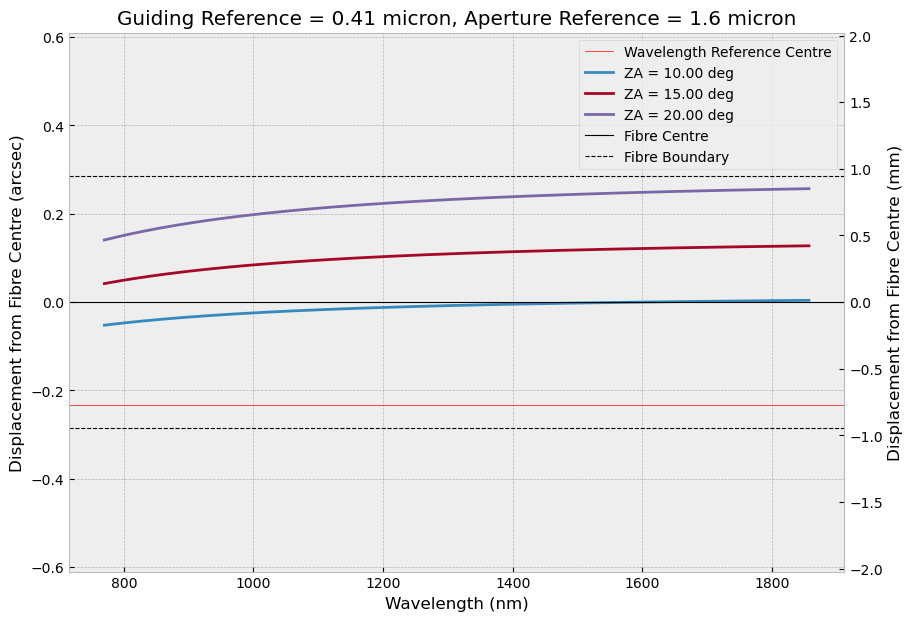

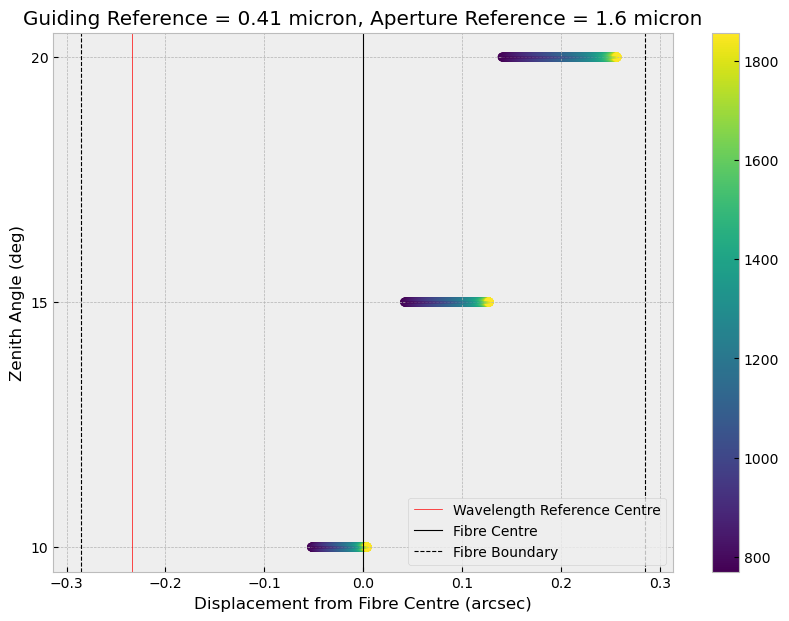

In [5]:
#Following is what is needed to plot the Wavelength vs Displacement and Displacement vs Airmass graphs. 
#Can switch out HA and ZA as needed in load_airmasses

analysis=AD_analysis() #Initialise class
# analysis.load_airmasses(HA_range=[0,1,2,3],targ_dec=10 * u.deg) #Generate airmasses (with HA)
analysis.load_airmasses(ZA_range=[10,15,20],targ_dec=10 * u.deg) #Generate airmasses (with ZA)
analysis.load_wave("LR","NIR","IY","H") #Generate the wavelengths to use. Third and fourth terms are the start band and end band (can be the same)
analysis.calculate_shifts(fibrecentre_waveref = 1.6 * u.micron,reposition=False,guide_waveref=0.41*u.micron) #Calculates the shifts
shift_plot_v0(analysis.input_parameters,analysis.output_parameters,analysis.conditions) #Plot the graphs


#### (Better graphs) Displacement vs Airmass for various wavelengths
Only works for HA, but converts to ZA and plots scale too

In [4]:
#Following function is used to plot the Displacement vs Airmass graphs for a single observation mode (i.e. purely VIS or NIR)
def shift_plot_v1(input_parameters,output_parameters,conditions): 
    HA_range=input_parameters['HA_range']

    centre_shift=atm_diff.diff_shift(input_parameters['fibrecentre_waveref'],output_parameters['airmasses'][0],input_parameters['guide_waveref'],conditions)
    to_HA = lambda ZA_vals: atm_diff.ZA_2_HA(ZA_vals,input_parameters['targ_dec'])
    to_ZA = lambda HA_vals: atm_diff.HA_2_ZA(HA_vals,input_parameters['targ_dec'])
    fig, [ax, ax3] = plt.subplots(1,2, figsize=(10,4),gridspec_kw=dict(width_ratios=[10,.2]))    
    ax2 = ax.secondary_yaxis("right", functions=(to_ZA, to_HA))
    
    if input_parameters['reposition'] == False and analysis.input_parameters['fibrecentre_waveref'] != analysis.input_parameters['guide_waveref']: #If repositioned, wavelength reference centre is meaningless as relative position changes
        plt.axvline(-centre_shift.value,linewidth=0.5,color='red',label='Guiding Wavelength Position')
        
    xvals=np.linspace(-1,1,len(output_parameters['wave_wavelengths']))
    c=np.tan(xvals)
    
    for i in range(0,len(output_parameters['shifts'])):
        yvals=np.full(len(output_parameters['shifts'][i]),HA_range[i])
        ax.scatter(output_parameters['shifts'][i],yvals,c=c,cmap='inferno')
        norm = plt.Normalize(output_parameters['wave_wavelengths'].value.min(), output_parameters['wave_wavelengths'].value.max())
        points = np.array([output_parameters['shifts'][i], yvals]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap='inferno', norm=norm)
        lc.set_array(output_parameters['wave_wavelengths'].value)
        lc.set_linewidth(2)
        line=ax.add_collection(lc)
        
    fig.colorbar(line, label='Wavelength (nm)',cax=ax3)
    ax.axvline(0,linewidth=0.7,color='black',label='Aperture Centre')
    ax.axvline(output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',label='Aperture Boundary',linestyle='--')
    ax.axvline(-output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',linestyle='--')
    ax.set_xlabel('Displacement from Aperture Centre (arcsec)')
    ax.set_ylabel('Hour Angle (h)')
    ax2.set_ylabel("Zenith Angle (deg)")
    ax.set_yticks(np.linspace(min(HA_range),max(HA_range),len(HA_range)))
    ax.legend()
    ax.set_title('%s %s, Guiding = %s, Aperture = %s, Dec = %2.2f' %(input_parameters['regime'], input_parameters['band'],input_parameters['guide_waveref'],input_parameters['fibrecentre_waveref'],input_parameters['targ_dec'].value))    

Target goes below Horizon above/below HA of +/- 6.0h


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "b_box" which is no longer supported as of 3.3 and will become an error in 3.6
  import sys
/Users/Jay.Stephan/Library/CloudStorage/OneDrive-ScienceandTechnologyFacilitiesCouncil/Documents/Work/MOSAIC/AD/AD-Code/Main-Version/Atmospheric_diffraction.py:114: RuntimeWarning: invalid value encountered in arccos
  HA = np.arccos((np.sin(alt)-np.sin(lat)*np.sin(dec))/(np.cos(lat)*np.cos(dec)))


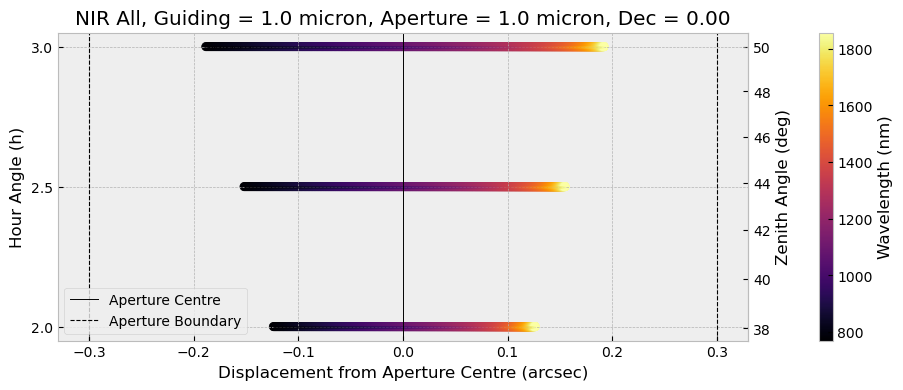

In [5]:
#Following code plots single mode observation
analysis=AD_analysis()
analysis.load_airmasses(HA_range=[2,2.5,3],targ_dec=0 * u.deg) #HAS TO BE IN HA!
analysis.load_wave("LR","NIR","IY","H")
analysis.calculate_shifts(fibrecentre_waveref = 1 * u.micron,reposition=False,guide_waveref=1*u.micron)
shift_plot_v1(analysis.input_parameters,analysis.output_parameters,analysis.conditions)
plt.savefig("graphs/NIR_2D.png",dpi=600,b_box="tight")

Target goes below Horizon above/below HA of +/- 6.0h
Target goes below Horizon above/below HA of +/- 6.0h


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:97: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "b_box" which is no longer supported as of 3.3 and will become an error in 3.6


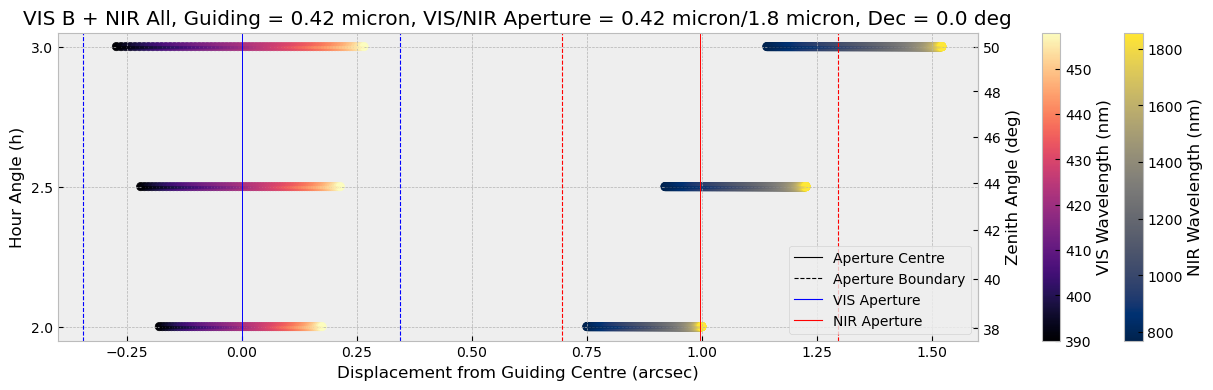

In [6]:
#Following code is for parallel mode observations.
#Change the following parameters for the observations appropriately
#Depending on the config used, the x-limits will also need to be changed at the code bottom

HA_vals=[2,2.5,3] #Airmass has to be in HA
dec = 0 * u.deg
guide = 0.42 * u.micron
VIS_aperture=0.42 * u.micron
NIR_aperture=1.8 * u.micron
VIS_mode=["LR","VIS","B","B"]
NIR_mode=["LR","NIR","IY","H"]

#===========================
#VIS
analysis=AD_analysis()
analysis.load_airmasses(HA_range=HA_vals,targ_dec=dec ) 
analysis.load_wave(VIS_mode[0],"VIS",VIS_mode[2],VIS_mode[3]) 
analysis.calculate_shifts(fibrecentre_waveref = VIS_aperture,reposition=False,guide_waveref=guide)

input_parameters=analysis.input_parameters
output_parameters=analysis.output_parameters
conditions=analysis.conditions

HA_range=input_parameters['HA_range']
HA_to_ZA_range=atm_diff.HA_2_ZA(HA_range,input_parameters['targ_dec'])

centre_shift=atm_diff.diff_shift(input_parameters['fibrecentre_waveref'],output_parameters['airmasses'][0],input_parameters['guide_waveref'],conditions)
T_arc = lambda T_mm: T_mm * analysis.plate_scale
T_mm = lambda T_arc: T_arc / analysis.plate_scale

to_HA = lambda ZA_vals: atm_diff.ZA_2_HA(ZA_vals,input_parameters['targ_dec'])
to_ZA = lambda HA_vals: atm_diff.HA_2_ZA(HA_vals,input_parameters['targ_dec'])
fig, [ax, ax3, ax4] = plt.subplots(1,3, figsize=(14,4),gridspec_kw=dict(width_ratios=[10,.2,.2]))
ax2 = ax.secondary_yaxis("right", functions=(to_ZA, to_HA))

xvals=np.linspace(-1,1,len(output_parameters['wave_wavelengths']))
c=np.tan(xvals)
for i in range(0,len(output_parameters['shifts'])):
    yvals=np.full(len(output_parameters['shifts'][i]),HA_range[i])
    ax.scatter(output_parameters['shifts'][i]+centre_shift,yvals,c=c,cmap='magma')
    norm = plt.Normalize(output_parameters['wave_wavelengths'].value.min(), output_parameters['wave_wavelengths'].value.max())
    points = np.array([output_parameters['shifts'][i]+centre_shift, yvals]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='magma', norm=norm)
    lc.set_array(output_parameters['wave_wavelengths'].value)
    lc.set_linewidth(2)
    line=ax.add_collection(lc)

ax.axvline(0+centre_shift.value,linewidth=0.7,color='blue')
ax.axvline(output_parameters['fibre_diameter'].value/2+centre_shift.value,linewidth=0.8,color='blue',linestyle='--')
ax.axvline(-output_parameters['fibre_diameter'].value/2+centre_shift.value,linewidth=0.8,color='blue',linestyle='--')
ax.set_xlabel('Displacement from Guiding Centre (arcsec)')
ax.set_ylabel('Hour Angle (h)')
ax2.set_ylabel("Zenith Angle (deg)")
ax.set_yticks(np.linspace(min(HA_range),max(HA_range),len(HA_range)))

#NIR
analysis=AD_analysis()
analysis.load_airmasses(HA_range=HA_vals,targ_dec=dec ) 
analysis.load_wave(NIR_mode[0],"NIR",NIR_mode[2],NIR_mode[3])
analysis.calculate_shifts(fibrecentre_waveref = NIR_aperture,reposition=False,guide_waveref=guide) 
input_parameters=analysis.input_parameters
output_parameters=analysis.output_parameters
conditions=analysis.conditions

centre_shift=atm_diff.diff_shift(input_parameters['fibrecentre_waveref'],output_parameters['airmasses'][0],input_parameters['guide_waveref'],conditions)
xvals=np.linspace(-1,1,len(output_parameters['wave_wavelengths']))
c=np.tan(xvals)
for i in range(0,len(output_parameters['shifts'])):
    yvals=np.full(len(output_parameters['shifts'][i]),HA_range[i])
    ax.scatter(output_parameters['shifts'][i]+centre_shift,yvals,c=c,cmap='cividis')
    norm = plt.Normalize(output_parameters['wave_wavelengths'].value.min(), output_parameters['wave_wavelengths'].value.max())
    points = np.array([output_parameters['shifts'][i]+centre_shift, yvals]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='cividis', norm=norm)
    lc.set_array(output_parameters['wave_wavelengths'].value)
    lc.set_linewidth(2)
    line2=ax.add_collection(lc)
fig.colorbar(line2, label='NIR Wavelength (nm)',cax=ax4)
fig.colorbar(line, label='VIS Wavelength (nm)',cax=ax3)
ax.axvline(0+centre_shift.value,linewidth=0.7,color='red')
ax.axvline(+output_parameters['fibre_diameter'].value/2+centre_shift.value,linewidth=0.8,color='red',linestyle='--')
ax.axvline(-output_parameters['fibre_diameter'].value/2+centre_shift.value,linewidth=0.8,color='red',linestyle='--')

#Legend details
ax.axvline(-100,linewidth=0.8,color='black',label='Aperture Centre')
ax.axvline(-100,linewidth=0.8,color='black',label='Aperture Boundary',linestyle='--')
ax.axvline(-100,linewidth=0.8,color='blue',label='VIS Aperture')
ax.axvline(-100,linewidth=0.8,color='red',label='NIR Aperture')
ax.legend(loc=4)

ax.set_title('VIS %s + NIR %s, Guiding = %s, VIS/NIR Aperture = %s/%s, Dec = %s' %(VIS_mode[2],analysis.input_parameters['band'],guide,VIS_aperture,NIR_aperture,dec)) 

#=============

ax.set_xlim(-0.4,1.6) #* needs to be changed depending on config used
plt.savefig("graphs/Parallel_2D.png",dpi=600,b_box="tight")

#### Red/Blue Seperation for Bands as a function of Zenith Angle/Airmass

In [7]:
#Following function calculates blue/red seperations for bands/modes in the config list - i.e [["NIR", "LR","IY","H"],....]
def red_blue_separation(config):
    separations=[]
    for i in config:
        Config_regime = ConfigObj('./Architecture_parameters/'+i[0]+'_channel_conf.ini')
        sampling = -int(Config_regime[i[1]]['Bands'][i[2]]['wave_min'])+int(Config_regime[i[1]]['Bands'][i[3]]['wave_max'])
        analysis.load_wave(i[1],i[0],i[2],i[3],sampling * u.nm)
        analysis.calculate_shifts(fibrecentre_waveref = 100 * u.micron, reposition=False, guide_waveref=200 * u.micron)
        separation=[]
        for o in analysis.output_parameters['shifts']:
            separation.append(abs(o[0]-o[1]).value)
        separations.append(separation)
    return separations

In [8]:
angles=ZA_range=np.arange(0,60) #Angles to calculate blue/red shift over
analysis=AD_analysis()
analysis.load_airmasses(ZA_range=angles) #Generates relevant airmasses

#All MOSAIC observing modes/bands:
NIR_LR=[["NIR","LR","IY","H"],["NIR","LR","J","J"],["NIR","LR","IY","IY"],["NIR","LR","H","H"]]
NIR_HR=[["NIR","HR","IY","H"],["NIR","HR","IY","IY"],["NIR","HR","H","H"]]
VIS_LR=[["VIS","LR","B","R"],["VIS","LR","B","B"],["VIS","LR","V","V"],["VIS","LR","R","R"]]
VIS_HR=[["VIS","HR","V","R"],["VIS","HR","V","V"],["VIS","HR","R","R"]]

#Generate seperations
NIR_LR_sep=red_blue_separation(NIR_LR)
NIR_HR_sep=red_blue_separation(NIR_HR)
VIS_LR_sep=red_blue_separation(VIS_LR)
VIS_HR_sep=red_blue_separation(VIS_HR)

(0.0, 2.5)

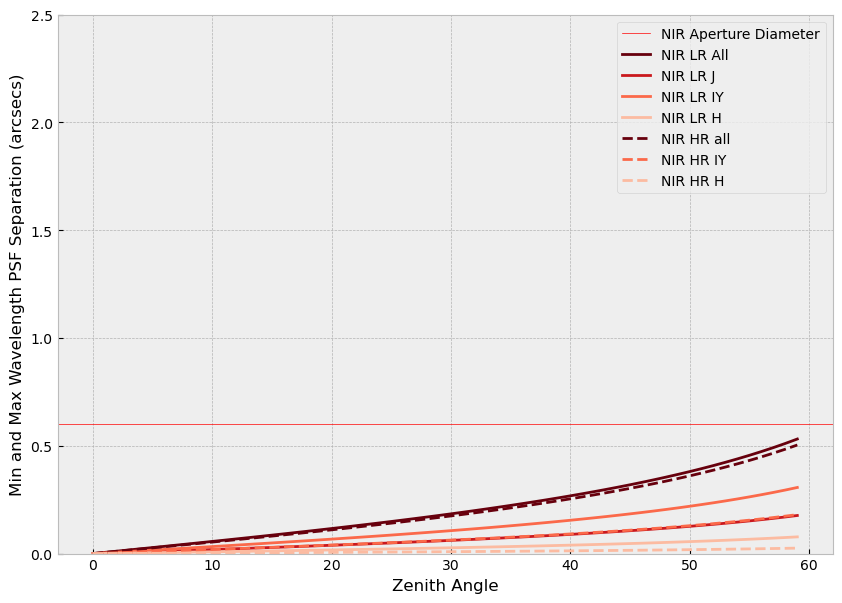

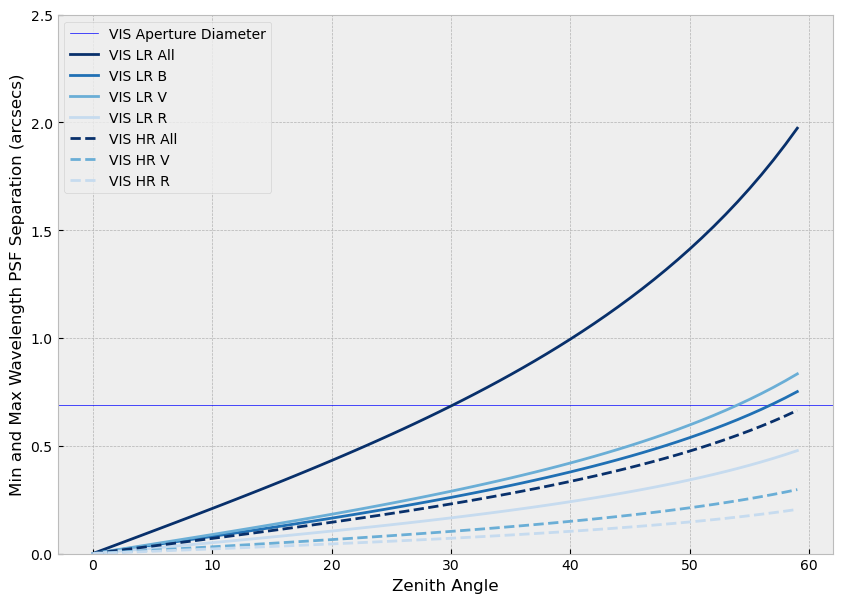

In [9]:
#Plots for the NIR and VIS respectively are generated below using those seperations
weights4 = np.arange(0, 4+1)
norm4 = mpl.colors.Normalize(vmin=min(weights4), vmax=max(weights4))
cmap4_1 = mpl.cm.ScalarMappable(norm=norm4, cmap=mpl.cm.Reds)
cmap4_2 = mpl.cm.ScalarMappable(norm=norm4, cmap=mpl.cm.Blues)

fig, ax = plt.subplots(figsize=(10,7))
plt.axhline(0.6,color='red',linewidth=0.5,label='NIR Aperture Diameter')
plt.plot(angles,NIR_LR_sep[0],label="NIR LR All",color=cmap4_1.to_rgba(3+1))
plt.plot(angles,NIR_LR_sep[1],label="NIR LR J",color=cmap4_1.to_rgba(2+1))
plt.plot(angles,NIR_LR_sep[2],label="NIR LR IY",color=cmap4_1.to_rgba(1+1))
plt.plot(angles,NIR_LR_sep[3],label="NIR LR H",color=cmap4_1.to_rgba(0+1))
plt.plot(angles,NIR_HR_sep[0],label="NIR HR all",color=cmap4_1.to_rgba(3+1),linestyle='--')
plt.plot(angles,NIR_HR_sep[1],label="NIR HR IY",color=cmap4_1.to_rgba(1+1),linestyle='--')
plt.plot(angles,NIR_HR_sep[2],label="NIR HR H",color=cmap4_1.to_rgba(0+1),linestyle='--')
plt.ylabel("Min and Max Wavelength PSF Separation (arcsecs)")
plt.xlabel("Zenith Angle")
plt.legend()
plt.ylim(0,2.5)

fig, ax = plt.subplots(figsize=(10,7))
plt.axhline(0.69,color='blue',linewidth=0.5,label='VIS Aperture Diameter')
plt.plot(angles,VIS_LR_sep[0],label="VIS LR All",color=cmap4_2.to_rgba(3+1))
plt.plot(angles,VIS_LR_sep[1],label="VIS LR B",color=cmap4_2.to_rgba(2+1))
plt.plot(angles,VIS_LR_sep[2],label="VIS LR V",color=cmap4_2.to_rgba(1+1))
plt.plot(angles,VIS_LR_sep[3],label="VIS LR R",color=cmap4_2.to_rgba(0+1))
plt.plot(angles,VIS_HR_sep[0],label="VIS HR All",color=cmap4_2.to_rgba(3+1),linestyle='--')
plt.plot(angles,VIS_HR_sep[1],label="VIS HR V",color=cmap4_2.to_rgba(1+1),linestyle='--')
plt.plot(angles,VIS_HR_sep[2],label="VIS HR R",color=cmap4_2.to_rgba(0+1),linestyle='--')
plt.ylabel("Min and Max Wavelength PSF Separation (arcsecs)")
plt.xlabel("Zenith Angle")
plt.legend()
plt.ylim(0,2.5)

## Transmission Snapshots
Transmission vs Wavelength for various Airmass


In [10]:
#Following function is used to plot the described graph
def trans_plot(input_parameters,output_parameters,conditions,normalise="none"):
    """
    normalise: string, "none", "zenith", "centre", "both"
        what to normalise the transmission to; either no normalisation, relative to zenith, or relative to transmission of fibre centre wavelength

    """
    airmasses=output_parameters['airmasses']
    ZA_range=input_parameters['ZA_range']
    HA_range=input_parameters['HA_range']
    
    wave_wavelengths=output_parameters['wave_wavelengths']
    fibre_diameter=output_parameters['fibre_diameter']
    wave_transmissions=output_parameters['wave_transmissions']
    
    fibrecentre_waveref=input_parameters['fibrecentre_waveref']
    guide_waveref=input_parameters['guide_waveref']
    median_FWHM=input_parameters['median_FWHM']
    median_FWHM_lambda=input_parameters['median_FWHM_lambda']
    kolb_factor=input_parameters['kolb_factor']
    regime=input_parameters['regime']
    k_lim=input_parameters['k_lim']
    FWHM_change=input_parameters['FWHM_change']
    scale=input_parameters['scale']
    method=input_parameters['method']
    beta=input_parameters['beta']
    band=input_parameters['band']
    targ_dec=input_parameters['targ_dec']
    
    weights = np.arange(1, len(airmasses)+3)
    norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
    if regime=="NIR":
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
    elif regime=="VIS":
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)

    fig, ax = plt.subplots(figsize=(7,5))
    plt.axvline(fibrecentre_waveref.value*1000,color='black',linewidth=0.5,label='Aperture Centre Wavelength')
    
    if HA_range != []:
        label="HA ="
        label_range=HA_range
        #plt.title('%s %s, Aperture Centre = %s, Dec = %s' %(regime,band,fibrecentre_waveref,targ_dec))
    else:
        label="ZA ="
        label_range=ZA_range
        #plt.title('%s %s, Aperture Centre = %s' %(regime,band,fibrecentre_waveref))

    if normalise == "zenith":
        print("Normalised to Zenith Transmission")
        if FWHM_change==True:
            zenith_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,1,median_FWHM,median_FWHM_lambda,kolb_factor)
        else:
            zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
        zenith_centre_shift=atm_diff.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
        zenith_shifts=atm_diff.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift
        if method == "analytical":
            zenith_transmission = trans_calc.analytical_gaussian(fibre_diameter,zenith_FWHMs,zenith_shifts,k_lim)
        if method == "numerical gaussian":
            zenith_transmission = []
            for i in range(0,len(zenith_FWHMs)):
                zenith_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale))
        if method == "numerical moffat":
            zenith_transmission = []
            for i in range(0,len(zenith_FWHMs)):
                zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
        for i in range(0,len(wave_transmissions)):
            plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(zenith_transmission),label='%s = %2.0f' %(label,label_range[i]),color=cmap.to_rgba(i+1))    
        plt.ylabel("Transmission Relative to Zenith")

    if normalise == "centre":
        print("Normalised to Reference Wavelength Transmission")
        peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]          
        for i in range(0,len(wave_transmissions)):
            plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(wave_transmissions[i][peak]),label='%s = %2.0f' %(label,label_range[i]),color=cmap.to_rgba(i+3))    
        plt.ylabel("Transmission Relative to Aperture Centre Wavelength")

    if normalise == "none":
        print("No Normalisation, Raw Transmission")
        for i in range(0,len(wave_transmissions)):
            plt.plot(wave_wavelengths,np.array(wave_transmissions[i]),label='%s = %2.0f' %(label,label_range[i]),color=cmap.to_rgba(3-i))
            #plt.plot(wave_wavelengths,np.array(wave_transmissions[i]),label='%s = %2.0f' %(label,label_range[i]),color=cmap.to_rgba(i+1))
        plt.ylabel("Transmission")

    plt.xlabel("Wavelength (nm)")
    plt.ylim(0,1.1)
    plt.legend()

Normalised to Reference Wavelength Transmission


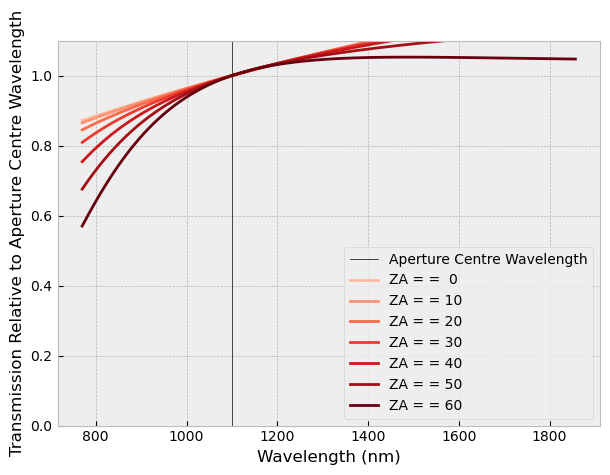

In [11]:
#Following code plots for NIR all
analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H') #Generate wavelengths
analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60]) #Generate airmasses
#analysis.load_airmasses(HA_range=[0,1,2],targ_dec= 0 * u.degree)
analysis.calculate_shifts(fibrecentre_waveref = 1.1 * u.micron,reposition=True, guide_waveref=5 * u.micron) #Calculate shifts
analysis.calculate_transmissions(method="numerical moffat") #Calculate transmissions
trans_plot(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="centre")

Normalised to Reference Wavelength Transmission


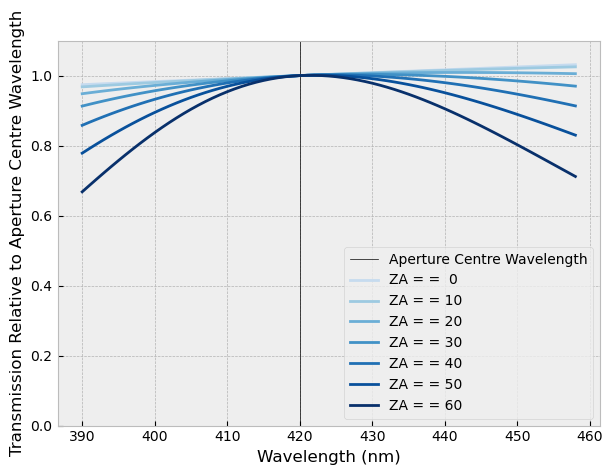

In [12]:
#Following code plots for VIS B, VIS V, and VIS R
analysis=AD_analysis()
analysis.load_wave('LR','VIS','B','B')
analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])
analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)
analysis.calculate_transmissions(method="numerical moffat")
trans_plot(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="centre")




In [13]:
#Following function is used to plot the described graph
def trans_plot2(input_parameters,output_parameters,conditions,normalise="none"):
    """
    normalise: string, "none", "zenith", "centre", "both"
        what to normalise the transmission to; either no normalisation, relative to zenith, or relative to transmission of fibre centre wavelength

    """
    airmasses=output_parameters['airmasses']
    ZA_range=input_parameters['ZA_range']
    HA_range=input_parameters['HA_range']
    
    wave_wavelengths=output_parameters['wave_wavelengths']
    fibre_diameter=output_parameters['fibre_diameter']
    wave_transmissions=output_parameters['wave_transmissions']
    
    fibrecentre_waveref=input_parameters['fibrecentre_waveref']
    guide_waveref=input_parameters['guide_waveref']
    median_FWHM=input_parameters['median_FWHM']
    median_FWHM_lambda=input_parameters['median_FWHM_lambda']
    kolb_factor=input_parameters['kolb_factor']
    regime=input_parameters['regime']
    k_lim=input_parameters['k_lim']
    FWHM_change=input_parameters['FWHM_change']
    scale=input_parameters['scale']
    method=input_parameters['method']
    beta=input_parameters['beta']
    band=input_parameters['band']
    targ_dec=input_parameters['targ_dec']
    
    weights = np.arange(1, len(airmasses)+3)
    norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
    if regime=="NIR":
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
    elif regime=="VIS":
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)

    
    
    
    if HA_range != []:
        label="HA ="
        label_range=HA_range
        #plt.title('%s %s, Aperture Centre = %s, Dec = %s' %(regime,band,fibrecentre_waveref,targ_dec))
    else:
        label="ZA ="
        label_range=ZA_range
        #plt.title('%s %s, Aperture Centre = %s' %(regime,band,fibrecentre_waveref))

    if normalise == "zenith":
        print("Normalised to Zenith Transmission")
        if FWHM_change==True:
            zenith_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,1,median_FWHM,median_FWHM_lambda,kolb_factor)
        else:
            zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
        zenith_centre_shift=atm_diff.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
        zenith_shifts=atm_diff.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift
        if method == "analytical":
            zenith_transmission = trans_calc.analytical_gaussian(fibre_diameter,zenith_FWHMs,zenith_shifts,k_lim)
        if method == "numerical gaussian":
            zenith_transmission = []
            for i in range(0,len(zenith_FWHMs)):
                zenith_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale))
        if method == "numerical moffat":
            zenith_transmission = []
            for i in range(0,len(zenith_FWHMs)):
                zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
        for i in range(0,len(wave_transmissions)):
            plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(zenith_transmission),label='%s' %(analysis.conditions['pressure']))    
        plt.ylabel("Transmission Relative to Zenith")

    if normalise == "centre":
        print("Normalised to Reference Wavelength Transmission")
        peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]          
        for i in range(0,len(wave_transmissions)):
            plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(wave_transmissions[i][peak]),label='%s' %(analysis.conditions['pressure']))      
        plt.ylabel("Transmission Relative to Aperture Centre Wavelength")

    if normalise == "none":
        print("No Normalisation, Raw Transmission")
        for i in range(0,len(wave_transmissions)):
            plt.plot(wave_wavelengths,np.array(wave_transmissions[i]),label='%s = %2.0f' %(label,label_range[i]),color=cmap.to_rgba(3-i))
            #plt.plot(wave_wavelengths,np.array(wave_transmissions[i]),label='%s = %2.0f' %(label,label_range[i]),color=cmap.to_rgba(i+1))
        plt.ylabel("Transmission")

    plt.xlabel("Wavelength (nm)")
    plt.ylim(0,1.1)


Normalised to Reference Wavelength Transmission
Normalised to Reference Wavelength Transmission


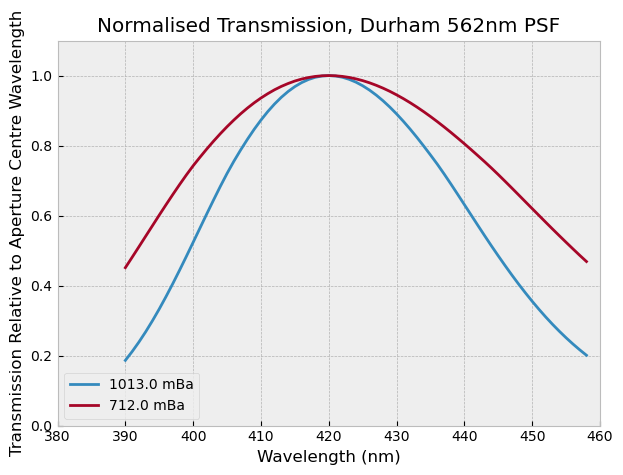

In [14]:
#Following code plots for VIS B, VIS V, and VIS R
fig, ax = plt.subplots(figsize=(7,5))
analysis=AD_analysis()
#analysis.conditions['temperature']=(293-273.15)*u.deg_C
analysis.conditions['pressure']=1013*u.mBa
#analysis.conditions['humidity']=15*u.percent

analysis.load_wave('LR','VIS','B','B')
analysis.load_airmasses(ZA_range=[60])

analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)

analysis.calculate_transmissions(method="numerical durham")
trans_plot2(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="centre")
plt.xlim(380,460)
plt.title("Normalised Transmission, Durham 562nm PSF")

#Following code plots for VIS B, VIS V, and VIS R
analysis=AD_analysis()


analysis.load_wave('LR','VIS','B','B')
analysis.load_airmasses(ZA_range=[60])

analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)

analysis.calculate_transmissions(method="numerical durham")
trans_plot2(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="centre")
plt.xlim(380,460)
plt.legend(loc=3)

No Normalisation, Raw Transmission
No Normalisation, Raw Transmission
No Normalisation, Raw Transmission


Text(0.5, 1.0, 'Raw Transmision, Moffat PSF')

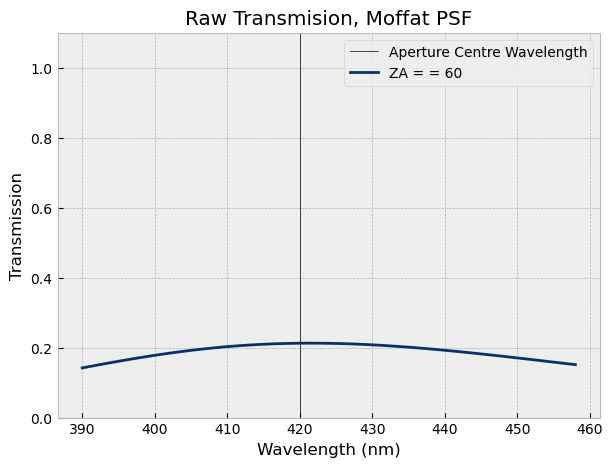

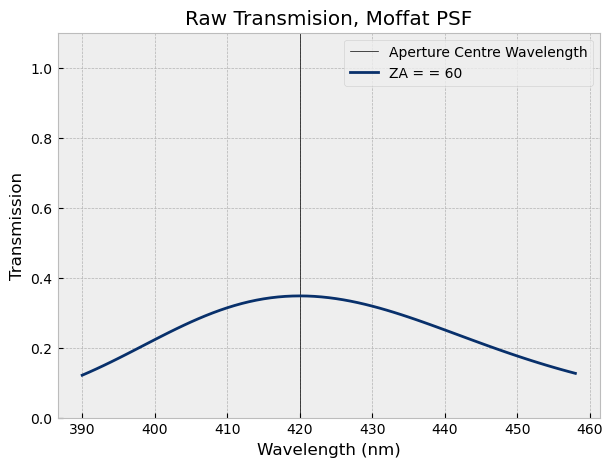

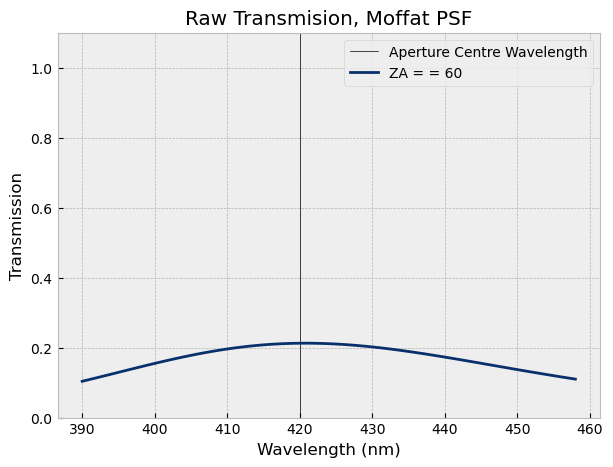

In [15]:

#Following code plots for VIS B, VIS V, and VIS R
analysis=AD_analysis()

analysis.load_wave('LR','VIS','B','B')
analysis.load_airmasses(ZA_range=[60])
analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)
analysis.calculate_transmissions(method="numerical moffat",FWHM_change=True)
trans_plot(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="none")
plt.title("Raw Transmision, Moffat PSF")

#Following code plots for VIS B, VIS V, and VIS R
analysis=AD_analysis()
analysis.conditions['temperature']=(293-273.15)*u.deg_C
analysis.conditions['pressure']=1013*u.mBa
analysis.conditions['humidity']=15*u.percent

analysis.load_wave('LR','VIS','B','B')
analysis.load_airmasses(ZA_range=[60])
analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)
analysis.calculate_transmissions(method="numerical moffat",FWHM_change=False)
trans_plot(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="none")
plt.title("Raw Transmision, Moffat PSF")

#Following code plots for VIS B, VIS V, and VIS R
analysis=AD_analysis()
analysis.conditions['temperature']=(293-273.15)*u.deg_C
analysis.conditions['pressure']=1013*u.mBa
analysis.conditions['humidity']=15*u.percent

analysis.load_wave('LR','VIS','B','B')
analysis.load_airmasses(ZA_range=[60])
analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)
analysis.calculate_transmissions(method="numerical moffat",FWHM_change=True)
trans_plot(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="none")
plt.title("Raw Transmision, Moffat PSF")

Normalised to Reference Wavelength Transmission
Normalised to Reference Wavelength Transmission


Text(0.5, 1.0, 'Raw Transmision, Moffat PSF')

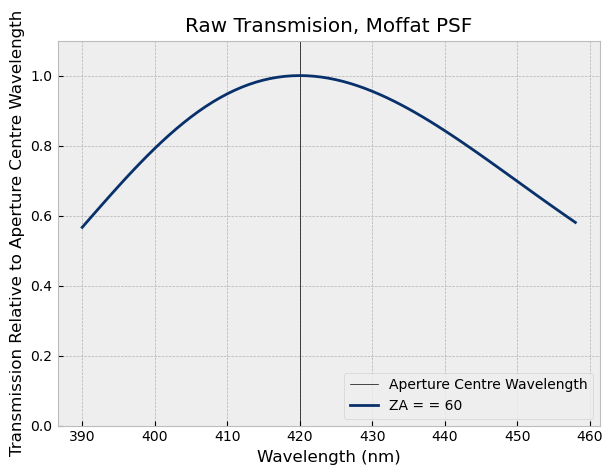

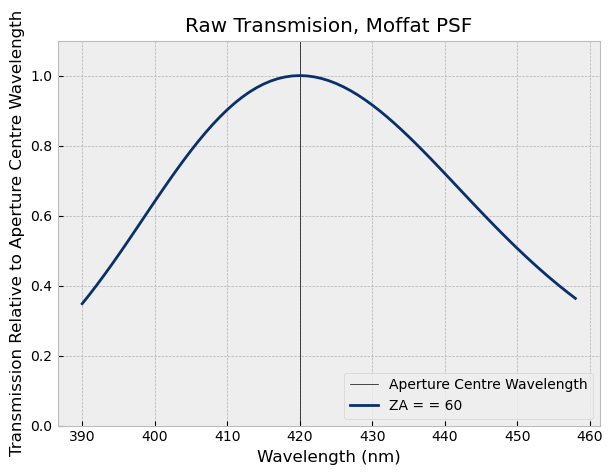

In [16]:

#Following code plots for VIS B, VIS V, and VIS R
analysis=AD_analysis()

analysis.load_wave('LR','VIS','B','B')
analysis.load_airmasses(ZA_range=[60])
analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)
analysis.calculate_transmissions(method="numerical moffat",FWHM_change=False)
trans_plot(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="centre")
plt.title("Raw Transmision, Moffat PSF")

#Following code plots for VIS B, VIS V, and VIS R
analysis=AD_analysis()
analysis.conditions['temperature']=(293-273.15)*u.deg_C
analysis.conditions['pressure']=1013*u.mBa
analysis.conditions['humidity']=15*u.percent

analysis.load_wave('LR','VIS','B','B')
analysis.load_airmasses(ZA_range=[60])
analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)
analysis.calculate_transmissions(method="numerical moffat",FWHM_change=False)
trans_plot(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="centre")
plt.title("Raw Transmision, Moffat PSF")

In [17]:
#Following function is used to plot the described graph
def trans_plot3(input_parameters,output_parameters,conditions,normalise="none"):
    """
    normalise: string, "none", "zenith", "centre", "both"
        what to normalise the transmission to; either no normalisation, relative to zenith, or relative to transmission of fibre centre wavelength

    """
    airmasses=output_parameters['airmasses']
    ZA_range=input_parameters['ZA_range']
    HA_range=input_parameters['HA_range']
    
    wave_wavelengths=output_parameters['wave_wavelengths']
    fibre_diameter=output_parameters['fibre_diameter']
    wave_transmissions=output_parameters['wave_transmissions']
    
    fibrecentre_waveref=input_parameters['fibrecentre_waveref']
    guide_waveref=input_parameters['guide_waveref']
    median_FWHM=input_parameters['median_FWHM']
    median_FWHM_lambda=input_parameters['median_FWHM_lambda']
    kolb_factor=input_parameters['kolb_factor']
    regime=input_parameters['regime']
    k_lim=input_parameters['k_lim']
    FWHM_change=input_parameters['FWHM_change']
    scale=input_parameters['scale']
    method=input_parameters['method']
    beta=input_parameters['beta']
    band=input_parameters['band']
    targ_dec=input_parameters['targ_dec']
    
    weights = np.arange(1, len(airmasses)+3)
    norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
    if regime=="NIR":
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
    elif regime=="VIS":
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)

    
    
    
    if HA_range != []:
        label="HA ="
        label_range=HA_range
        #plt.title('%s %s, Aperture Centre = %s, Dec = %s' %(regime,band,fibrecentre_waveref,targ_dec))
    else:
        label="ZA ="
        label_range=ZA_range
        #plt.title('%s %s, Aperture Centre = %s' %(regime,band,fibrecentre_waveref))

    if normalise == "zenith":
        print("Normalised to Zenith Transmission")
        if FWHM_change==True:
            zenith_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,1,median_FWHM,median_FWHM_lambda,kolb_factor)
        else:
            zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
        zenith_centre_shift=atm_diff.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
        zenith_shifts=atm_diff.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift
        if method == "analytical":
            zenith_transmission = trans_calc.analytical_gaussian(fibre_diameter,zenith_FWHMs,zenith_shifts,k_lim)
        if method == "numerical gaussian":
            zenith_transmission = []
            for i in range(0,len(zenith_FWHMs)):
                zenith_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale))
        if method == "numerical moffat":
            zenith_transmission = []
            for i in range(0,len(zenith_FWHMs)):
                zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
        for i in range(0,len(wave_transmissions)):
            plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(zenith_transmission),label='%s' %(analysis.conditions['pressure']))    
        plt.ylabel("Transmission Relative to Zenith")

    if normalise == "centre":
        print("Normalised to Reference Wavelength Transmission")
        peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]          
        for i in range(0,len(wave_transmissions)):
            plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(wave_transmissions[0][peak]),label='%s' %(analysis.conditions['pressure']))      
        plt.ylabel("Transmission Relative to Aperture Centre Wavelength")

    if normalise == "none":
        print("No Normalisation, Raw Transmission")
        for i in range(0,len(wave_transmissions)):
            plt.plot(wave_wavelengths,np.array(wave_transmissions[i]),label='%s = %2.0f' %(label,label_range[i]),color=cmap.to_rgba(3-i))
            #plt.plot(wave_wavelengths,np.array(wave_transmissions[i]),label='%s = %2.0f' %(label,label_range[i]),color=cmap.to_rgba(i+1))
        plt.ylabel("Transmission")

    plt.xlabel("Wavelength (nm)")
    plt.ylim(0,1.1)


Normalised to Reference Wavelength Transmission
Normalised to Reference Wavelength Transmission


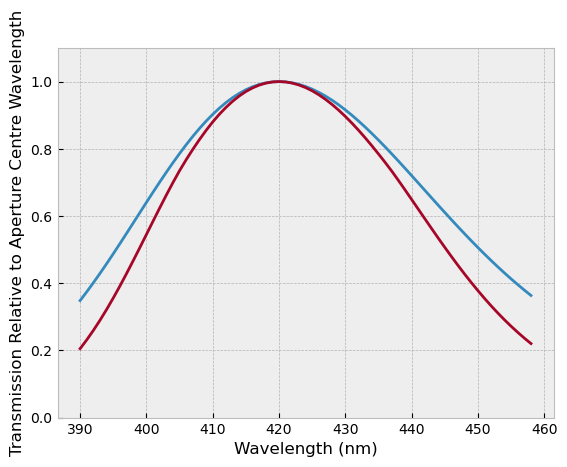

In [18]:
#Following code plots for VIS B, VIS V, and VIS R
analysis=AD_analysis()
analysis.conditions['temperature']=(293-273.15)*u.deg_C
analysis.conditions['pressure']=1013*u.mBa
analysis.conditions['humidity']=15*u.percent

analysis.load_wave('LR','VIS','B','B')
analysis.load_airmasses(ZA_range=[60])
analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)
analysis.calculate_transmissions(method="numerical moffat",FWHM_change=False)
trans_plot3(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="centre")


#Following code plots for VIS B, VIS V, and VIS R
analysis=AD_analysis()
analysis.conditions['temperature']=(293-273.15)*u.deg_C
analysis.conditions['pressure']=1013*u.mBa
analysis.conditions['humidity']=15*u.percent

analysis.load_wave('LR','VIS','B','B')
analysis.load_airmasses(ZA_range=[60])
analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)
analysis.calculate_transmissions(method="numerical durham",FWHM_change=False)
trans_plot3(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="centre")


Normalised to Reference Wavelength Transmission
Normalised to Reference Wavelength Transmission


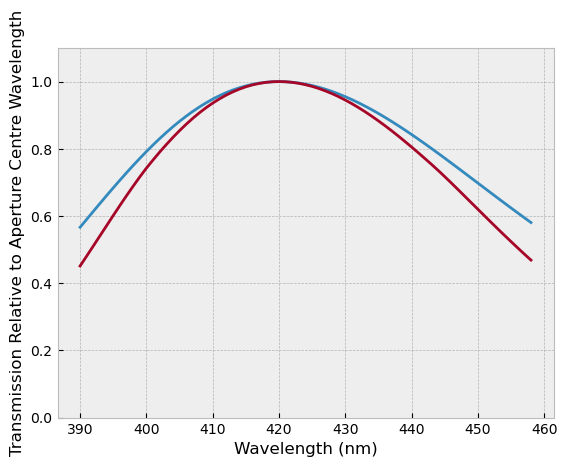

In [19]:
#Following code plots for VIS B, VIS V, and VIS R
analysis=AD_analysis()


analysis.load_wave('LR','VIS','B','B')
analysis.load_airmasses(ZA_range=[60])
analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)
analysis.calculate_transmissions(method="numerical moffat",FWHM_change=False)
trans_plot3(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="centre")


#Following code plots for VIS B, VIS V, and VIS R
analysis=AD_analysis()


analysis.load_wave('LR','VIS','B','B')
analysis.load_airmasses(ZA_range=[60])
analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)
analysis.calculate_transmissions(method="numerical durham",FWHM_change=False)
trans_plot3(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="centre")


Normalised to Reference Wavelength Transmission
Normalised to Reference Wavelength Transmission


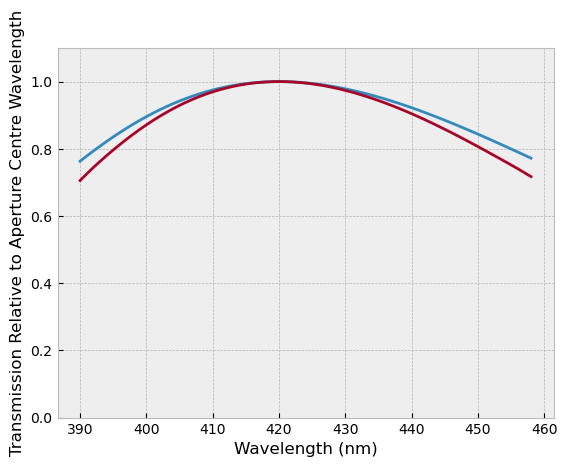

In [20]:
#Following code plots for VIS B, VIS V, and VIS R
analysis=AD_analysis()


analysis.load_wave('LR','VIS','B','B')
analysis.load_airmasses(ZA_range=[50])
analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)
analysis.calculate_transmissions(method="numerical moffat",FWHM_change=False)
trans_plot3(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="centre")


#Following code plots for VIS B, VIS V, and VIS R
analysis=AD_analysis()


analysis.load_wave('LR','VIS','B','B')
analysis.load_airmasses(ZA_range=[50])
analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)
analysis.calculate_transmissions(method="numerical durham",FWHM_change=False)
trans_plot3(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="centre")


Normalised to Reference Wavelength Transmission
Normalised to Reference Wavelength Transmission


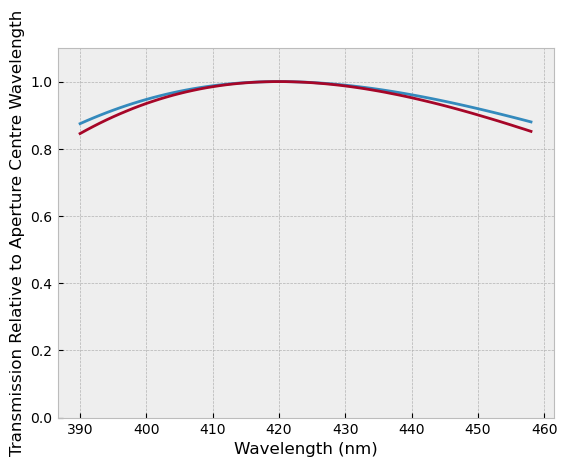

In [21]:
#Following code plots for VIS B, VIS V, and VIS R
analysis=AD_analysis()


analysis.load_wave('LR','VIS','B','B')
analysis.load_airmasses(ZA_range=[40])
analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)
analysis.calculate_transmissions(method="numerical moffat",FWHM_change=False)
trans_plot3(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="centre")


#Following code plots for VIS B, VIS V, and VIS R
analysis=AD_analysis()


analysis.load_wave('LR','VIS','B','B')
analysis.load_airmasses(ZA_range=[40])
analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)
analysis.calculate_transmissions(method="numerical durham",FWHM_change=False)
trans_plot3(analysis.input_parameters,analysis.output_parameters,analysis.conditions,normalise="centre")
